In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

class PolicyNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim, action_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, action_dim, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        a2 = F.softmax(l2, dim=1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return a2

class ActionValueNet(nn.Module) :
    def __init__(self, state_dim, hidden_dim, action_dim) :
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim, dtype=torch.float64)
        self.fc2 = nn.Linear(hidden_dim, action_dim, dtype=torch.float64)
        
    def forward(self, x) :
        l1 = self.fc1(x)
        a1 = F.relu(l1)
        l2 = self.fc2(a1)
        #print('x:',x.shape, "l1:", l1.shape, "a1:", a1.shape, "l2:", l2.shape, "a2:", a2.shape)
        return l2

import numpy as np

class Agent() :
    def __init__(self, state_dim, hidden_dim, action_dim, gamma, device) :
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # optimizer, lr,
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=0.0001)

        self.value_net = ActionValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=0.001)
        self.loss = nn.MSELoss()
        
        self.observation_list = []
        self.actions_list = []
        self.reward_list = []
        self.gamma = gamma

        self.device = device

        self.total_loss = []
        self.graph_tag = False
        
    def take_action(self, state, env) :
        state = torch.tensor(state, dtype=torch.float64).unsqueeze(0).to(self.device)
        actions = self.policy_net(state).squeeze()
        action = torch.distributions.Categorical(actions.detach()).sample().detach().cpu().numpy()
        return action

    def update(self, observation, action, reward, next_observation) : 
        # policy
        state = torch.tensor(observation, dtype=torch.float64).unsqueeze(0).to(self.device)
        G = self.value_net(state).squeeze()[action]
        actions = self.policy_net(state).squeeze()
        target = - actions[action].log() * G.detach()

        # value
        # next state action
        next_state = torch.tensor(next_observation, dtype=torch.float64).unsqueeze(0).to(self.device)
        next_actions = self.policy_net(next_state).squeeze()
        next_action = next_actions.argmax()
        #next_action = torch.distributions.Categorical(next_actions.detach()).sample()
        next_action_value = self.value_net(next_state).squeeze()[next_action]
        td_target = reward + self.gamma * next_action_value

        #print(G, td_target.squeeze())
        loss = self.loss(G, td_target.squeeze().detach())
        self.total_loss.append(loss.detach().cpu().numpy())

        if self.graph_tag == False :
            dot = make_dot(loss, params=dict(self.value_net.named_parameters()))
            dot.render("value_graph", format="png")

            dot = make_dot(target, params=dict(self.policy_net.named_parameters()))
            dot.render("policy_graph", format="png")
            self.graph_tag = True
            
        self.optimizer.zero_grad()
        self.value_optimizer.zero_grad()
            
        target.backward()
        loss.backward()
        self.optimizer.step()
        self.value_optimizer.step()

import os
os.environ['SDL_AUDIODRIVER'] = 'dummy'
os.environ['XDG_RUNTIME_DIR'] = '/home/youngsure/Code/tmp/'

import gymnasium as gym

# env init
env = gym.make("CartPole-v1", render_mode="rgb_array")
observation, info = env.reset(seed=0)
#print(observation)

# agent init
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
gamma = 0.98
agent = Agent(state_dim, hidden_dim, action_dim, gamma, 'cuda')

return_list = []
epoch_length_list = []

for i in range(1000) :
    observation, info = env.reset()#(seed=0)
    episode_over = False
    total_reward = 0
    epoch_length = 0
    
    while not episode_over:
        action = agent.take_action(observation, env)
        next_observation, reward, terminated, truncated, info = env.step(action)

        agent.update(observation, action, reward, next_observation)

        total_reward += reward
        observation = next_observation
        episode_over = terminated or truncated
        epoch_length += 1
        

    return_list.append(total_reward)
    epoch_length_list.append(epoch_length)
    if (i % 10 == 0) :
        print("Episode {} Total reward: {}".format(i, total_reward))
env.close()

Episode 0 Total reward: 21.0
Episode 10 Total reward: 19.0
Episode 20 Total reward: 11.0
Episode 30 Total reward: 14.0
Episode 40 Total reward: 13.0
Episode 50 Total reward: 18.0
Episode 60 Total reward: 12.0
Episode 70 Total reward: 10.0
Episode 80 Total reward: 13.0
Episode 90 Total reward: 9.0
Episode 100 Total reward: 9.0
Episode 110 Total reward: 9.0
Episode 120 Total reward: 9.0
Episode 130 Total reward: 10.0
Episode 140 Total reward: 9.0
Episode 150 Total reward: 9.0
Episode 160 Total reward: 10.0
Episode 170 Total reward: 10.0
Episode 180 Total reward: 10.0
Episode 190 Total reward: 9.0
Episode 200 Total reward: 9.0
Episode 210 Total reward: 12.0
Episode 220 Total reward: 10.0
Episode 230 Total reward: 10.0
Episode 240 Total reward: 9.0
Episode 250 Total reward: 9.0
Episode 260 Total reward: 10.0
Episode 270 Total reward: 9.0
Episode 280 Total reward: 10.0
Episode 290 Total reward: 9.0
Episode 300 Total reward: 10.0
Episode 310 Total reward: 8.0
Episode 320 Total reward: 9.0
Ep

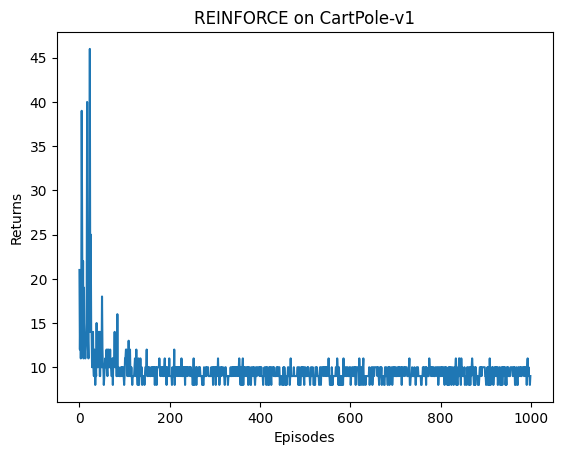

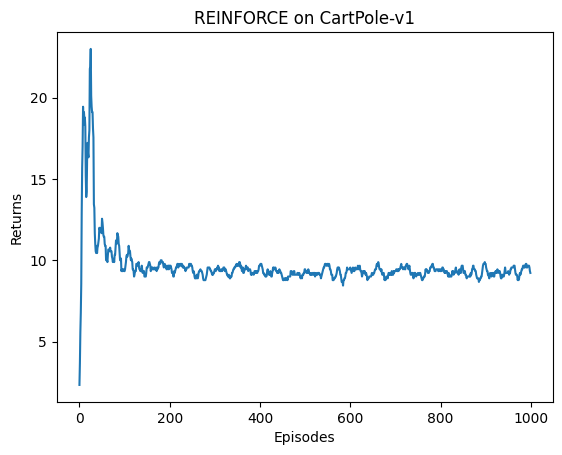

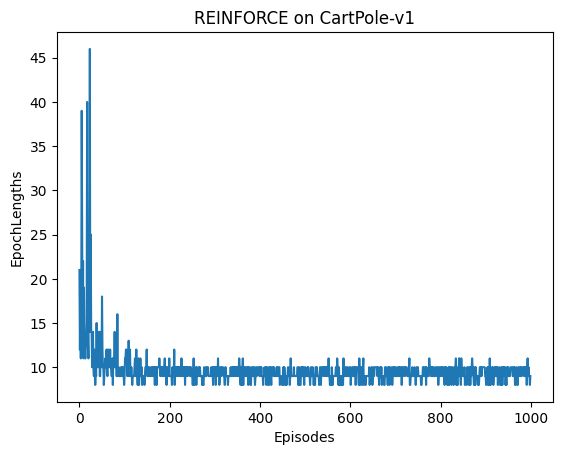

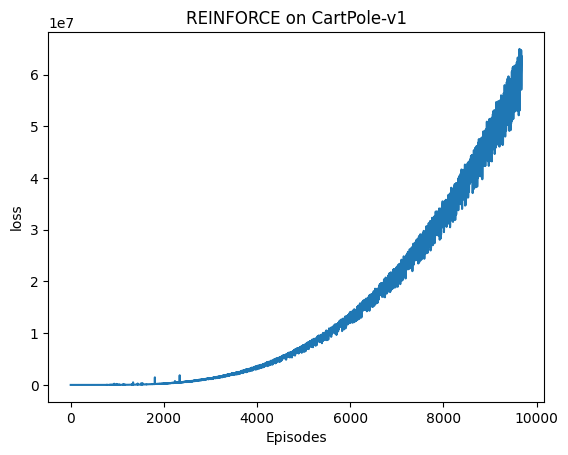

In [12]:
import matplotlib.pyplot as plt
env_name = "CartPole-v1"

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

def moving_average(targets, truncated_num) :
    truncated_sum = 0
    queue = []
    results = []
    for target in targets :
        queue.append(target)
        truncated_sum += target
        results.append(truncated_sum / truncated_num)
        if len(queue) == truncated_num :
            truncated_sum -= queue.pop(0)
            
    return results

mv_return = moving_average(return_list, 9)
#print(return_list, mv_return)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

episodes_list = list(range(len(epoch_length_list)))
plt.plot(episodes_list, epoch_length_list)
plt.xlabel('Episodes')
plt.ylabel('EpochLengths')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

episodes_list = list(range(len(agent.total_loss)))
plt.plot(episodes_list, agent.total_loss)
plt.xlabel('Episodes')
plt.ylabel('loss')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

两个网络不要搞混、不要交叉。  
这么理解，策略网络用到了价值网络的tensor，其实它只是用价值网络的估计值来引导自己而已，所以价值网络的tensor必须detach()  
反之亦然，这两个网络间不能有任何传播图的交叉。  

遵照数学原理10.1的QAC实现，修改了很多版，reward都不增长